In [1]:
pip install tensorflow-gpu

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')

In [4]:
if physical_devices:
    tf.config.set_visible_devices(physical_devices[0], 'GPU')  # Выбираем первый доступный GPU
    tf.config.experimental.set_memory_growth(physical_devices[0], True)  # Автоматическое управление памятью


In [5]:
data_path = '/content/drive/MyDrive/ML/COOKIE/info/data/act_dataset/'

df = pd.read_csv(data_path + 'targets_ds.csv', index_col=0)

In [6]:
import numpy as np
import os

os.chdir(data_path + 'данные_вибрации/2024_06_01/compilled_data/')

⬇ минут 5 выполняется, надо подождать ⬇

In [7]:
file_names = [f for f in os.listdir() if f.endswith(".npy")]

# Извлекаем времена и данные
vibro_time_list = [f[:-4] for f in file_names]
vibro_data = [np.fromfile(f, dtype=np.float32) for f in file_names]

# Преобразуем время в формате datetime
vibro_time_list = pd.to_datetime(vibro_time_list, format="%Y-%m-%d %H-%M-%S")

In [8]:
vibro_times_df = pd.DataFrame(vibro_time_list, columns=['t'])
vibro_times_df = vibro_times_df.sort_values(by='t')

vibro_df = vibro_times_df
vibro_df['data'] = pd.Series(vibro_data)

In [9]:
time_map = vibro_df.set_index('t')['data'].to_dict()

df['data'] = df['t'].map(time_map)

In [10]:
df.drop('t', axis=1, inplace=True)
df = df.dropna()
df

,gas_flowrate_m3day,liquid_flowrate_m3day,data
0,18.174109,124.918130,"[-0.05004253, -0.022564318, 0.0050759907, 0.03..."
1,24.173818,83.176202,"[-0.014703565, -0.011043415, -0.007609987, -0...."
2,36.278781,252.442349,"[0.07887097, 0.08665499, 0.09155335, 0.0916299..."
3,18.134775,125.538447,"[0.06893091, 0.07979776, 0.09098654, 0.1023827..."
4,24.163295,167.007924,"[0.02746108, 0.031360064, 0.032673102, 0.02980..."
...,...,...,...
1035,19.508934,64.539037,"[-0.03665114, -0.063533194, -0.0914695, -0.120..."
1036,6.588148,86.502914,"[0.1619212, 0.14040792, 0.11905427, 0.09952742..."
1037,6.624843,88.078710,"[-0.05321235, -0.0957351, -0.1317136, -0.15647..."
1038,19.865945,44.411194,"[0.02844854, 0.013625453, 0.00020921903, -0.01..."


In [11]:
df = df.reset_index()

In [12]:
from sklearn.model_selection import train_test_split

X = []

# Проходим по строкам df['data'] и извлекаем данные
for i in range(200):
    # Извлекаем данные для i-го примера (в каждой строке массива df['data'] - это один пример)
    data = np.fromiter(df['data'][i], dtype=np.float32)

    # Разбиваем данные на 4 канала, каждый из которых имеет длину 128000
    data_split = np.array_split(data, 4)  # Разбиваем на 4 части
    data_split = np.array(data_split).T  # Транспонируем, чтобы получить форму (128000, 4)

    # Добавляем результат в список
    X.append(data_split)

# Преобразуем список в numpy массив с нужной формой (960, 128000, 4)
X = np.array(X)

print(X.shape)

(200, 128000, 4)


In [13]:
y_1 = df['liquid_flowrate_m3day']
y_2 = df['gas_flowrate_m3day']

y_1 = y_1.iloc[0:200].values
y_2 = y_2.iloc[0:200].values

y_1 = y_1.reshape(-1, 1)
y_2 = y_2.reshape(-1, 1)

y = np.concatenate([y_1, y_2], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#FTT Модель

In [23]:
def conv_block(tensor, filters, kernel_size, activation, strides=1, dropout=0):
  conv_layer = tf.keras.layers.Conv1D(filters=filters,
                                      kernel_size=kernel_size,
                                      strides=strides,
                                      padding='same',
                                      activation=None)(tensor)

  batch_norm_layer = tf.keras.layers.BatchNormalization()(conv_layer)
  activation_layer = tf.keras.layers.Activation(activation)(batch_norm_layer)
  dropout_layer = tf.keras.layers.Dropout(dropout)(activation_layer)

  pooling_layer = tf.keras.layers.MaxPool1D(pool_size=2,
                                            strides=2)(dropout_layer)

  return pooling_layer

def dense_block(tensor, units, activation, dropout=0.1):
  dense_layer = tf.keras.layers.Dense(units=units,
                                      activation=None)(tensor)
  batch_norm_layer = tf.keras.layers.BatchNormalization()(dense_layer)
  activation_layer = tf.keras.layers.Activation(activation)(batch_norm_layer)
  dropout_layer = tf.keras.layers.Dropout(dropout)(activation_layer)
  return dropout_layer

def get_model(input_shape=(128000, 4), depth=12):
  input_layer = tf.keras.layers.Input(shape=input_shape)

  #Encoder
  for i in range(depth):
    if i == 0:
      conv = conv_block(tensor=input_layer,
                        filters=32,
                        kernel_size=3,
                        activation='relu',
                        strides=1,
                        dropout=0.1)
    else:
      conv = conv_block(tensor=conv,
                        filters=32,
                        kernel_size=3,
                        activation='relu',
                        strides=1,
                        dropout=0.1)

  #Fully-connected
  flatten_layer = tf.keras.layers.Flatten()(conv)

  dense = dense_block(tensor=flatten_layer,
                      units=100,
                      activation=None)
  dense_norm = tf.keras.layers.BatchNormalization()(dense)
  act_dense = tf.keras.layers.Activation('relu')(dense_norm)

  dense = dense_block(tensor=flatten_layer,
                      units=50,
                      activation=None)
  dense_norm = tf.keras.layers.BatchNormalization()(dense)
  act_dense = tf.keras.layers.Activation('relu')(dense_norm)

  output_layer = tf.keras.layers.Dense(units=2,
                                      activation='relu')(dense)

  model = tf.keras.models.Model(input_layer, output_layer)

  model.compile(optimizer='adam', loss='mse', metrics=['mape'])

  return model

In [33]:
ftt_model = get_model()

In [34]:
ftt_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 128000, 4)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_24 (Conv1D)                   │ (None, 128000, 32)          │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (None, 128000, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_32 (Activation)           │ (None, 128000, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 128000, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_24 (MaxPooling1D)      │ (None, 64000, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_25 (Conv1D)                   │ (None, 64000, 32)           │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_33               │ (None, 64000, 32)           │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_33 (Activation)           │ (None, 64000, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 64000, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_25 (MaxPooling1D)      │ (None, 32000, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_26 (Conv1D)                   │ (None, 32000, 32)           │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_34               │ (None, 32000, 32)           │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_34 (Activation)           │ (None, 32000, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 32000, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_26 (MaxPooling1D)      │ (None, 16000, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_27 (Conv1D)                   │ (None, 16000, 32)           │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_35               │ (None, 16000, 32)           │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_35 (Activation)           │ (None, 16000, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 86,048 (336.12 KB)

 Trainable params: 85,180 (332.73 KB)

 Non-trainable params: 868 (3.39 KB)

In [35]:
np.max(abs(X_train))

1.0

In [36]:
X_train.shape

(160, 128000, 4)

In [37]:
y_norm_train = y_train / np.max(abs(y_train), axis=0)[None, :]

In [38]:
np.min(y_norm_train), np.max(y_norm_train)

(0.0, 1.0)

In [39]:
y_norm_train.shape

(160, 2)

In [40]:
history = ftt_model.fit(X_train, y_norm_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 31s 555ms/step - loss: 1.0006 - mape: 34962832.0000 - val_loss: 0.3473 - val_mape: 100.0000
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step - loss: 0.7739 - mape: 12609830.0000 - val_loss: 0.3473 - val_mape: 100.0000
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step - loss: 0.6277 - mape: 15753968.0000 - val_loss: 0.3473 - val_mape: 100.0000
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step - loss: 0.5260 - mape: 8619128.0000 - val_loss: 0.3473 - val_mape: 100.0000
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step - loss: 0.5418 - mape: 14860809.0000 - val_loss: 0.3473 - val_mape: 100.0000
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - loss: 0.5488 - mape: 14001830.0000 - val_loss: 0.3473 - val_mape: 100.0000
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step - loss: 0.3310 - mape: 809775.3125 - val_loss: 0.3473 - val_mape: 100.0000
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step - loss: 0.3531 - mape: 6937994.0000 - val_loss: 0.3473 

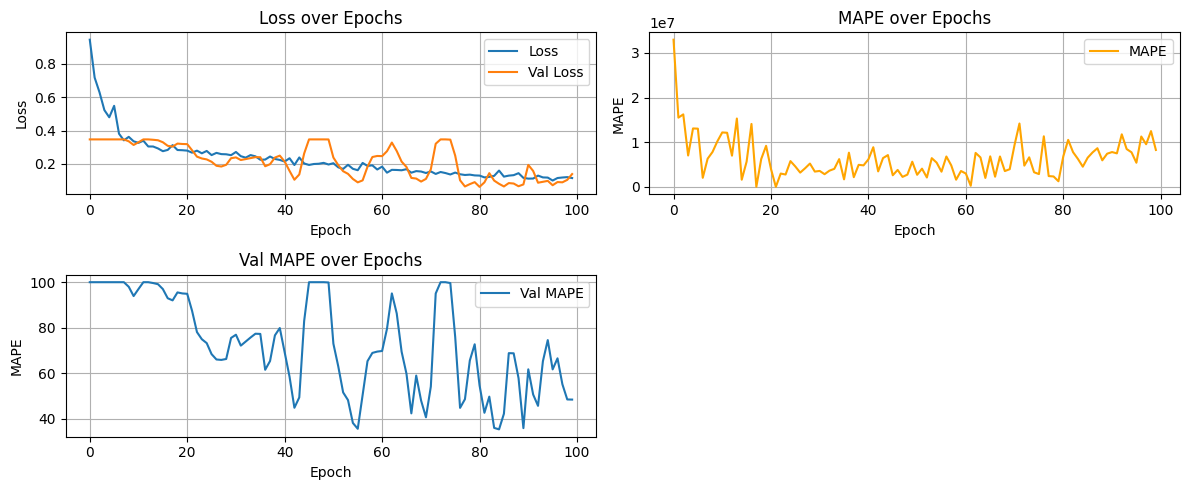

In [44]:
import matplotlib.pyplot as plt


loss_values = history.history['loss']
val_loss_values = history.history['val_loss']

mape_values = history.history['mape']
val_mape_values = history.history['val_mape']

# Построение графика loss
plt.figure(figsize=(12, 5))

# График для Loss
plt.subplot(2, 2, 1)
plt.plot(loss_values, label='Loss')
plt.plot(val_loss_values, label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# График для MAPE
plt.subplot(2, 2, 2)
plt.plot(mape_values, label='MAPE', color='orange')
plt.title('MAPE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAPE')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(val_mape_values, label='Val MAPE')
plt.title('Val MAPE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAPE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
loss, mae, mape_value = ftt_model.evaluate(X_test, {'y_1_output': y_test_1, 'y_2_output': y_test_2})

print(f'Test Loss: {loss}, MAE: {mae}, MAPE: {mape_value}')